<a href="https://colab.research.google.com/github/aborundiya/CNN/blob/master/BatchNorm_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import torchvision 
import torchvision.transforms as transforms
import torch 
import torch.nn as nn 
import torch.optim as optim 


#Dataset and visulization

In [0]:
transfom_train = transforms.Compose([
                                     transforms.ToTensor()
])

In [9]:
trainset = torchvision.datasets.MNIST('./data',train=True,download=True, transform=transfom_train)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


../torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


In [0]:
batch_size = 4 
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)


In [11]:
inputs, labels = iter(trainloader).next()
print(inputs.shape)
print(inputs[0].shape)
print(labels[0].item())



torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
0


In [0]:
def imshow(img, title):
  plt.figure(figsize=(batch_size * 4  , 4 ))
  plt.axis("off")
  plt.imshow(np.transpose(img,(1,2,0)))
  plt.title(title)
  plt.show()

In [0]:
def show_batch_images(dataloader):
  images , labels = iter(dataloader).next()
  img = torchvision.utils.make_grid(images)
  imshow(img, title= [str(x.item()) for x in labels])
  return images , labels 

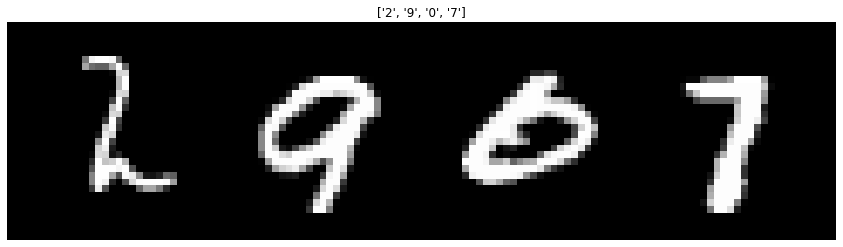

In [14]:
images , labels = show_batch_images(trainloader)

#Network design

In [0]:
class cnnMNIST(nn.Module):

  def __init__(self):
    super(cnnMNIST,self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(784,48),
        nn.ReLU(),
        nn.Linear(48,24),
        nn.ReLU(),
        nn.Linear(24,10)
    )

  def forward(self,x):
      x = x.view(x.size(0),-1)
      x = self.classifier(x)
      return x 

In [0]:
class cnnMNIST_BN(nn.Module):

  def __init__(self):
    super(cnnMNIST_BN,self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(784,48),
        nn.BatchNorm1d(48),
        nn.ReLU(),
        nn.Linear(48,24),
        nn.BatchNorm1d(24),
        nn.ReLU(),
        nn.Linear(24,10)
    )

  def forward(self,x):
    x = x.view(x.size(0),-1)
    x = self.classifier(x)
    return x

In [17]:
model = cnnMNIST()
print(model)

cnnMNIST(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [18]:
model_bn = cnnMNIST_BN()
print(model_bn)

cnnMNIST_BN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [0]:
batch_size = 512 
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)

In [0]:
loss_fn  = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(),lr= 0.01 )
opt_bn = optim.SGD(model_bn.parameters(),lr=0.01)


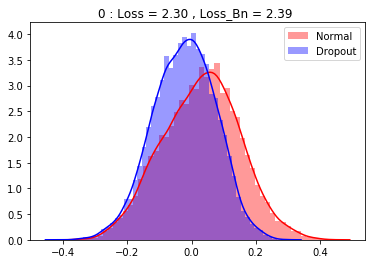

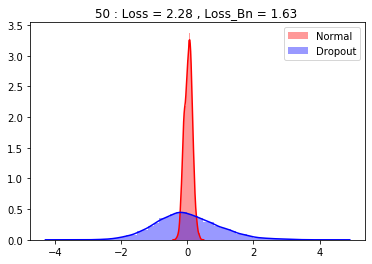

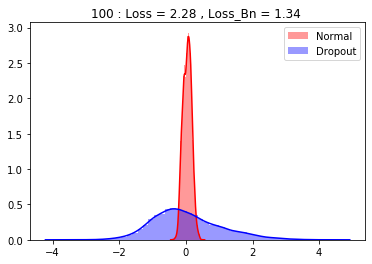

-------------------------------


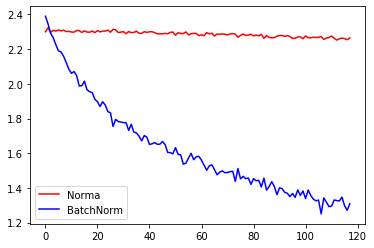

In [21]:
loss_arr = []
loss_arr_bn = []
max_epochs = 1 

for epoch in range(max_epochs):

  for i , data in enumerate(trainloader,0):
    inputs ,labels = data 
    #training without batch Normalize 
    opt.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    loss_arr.append(loss.item())

    opt_bn.zero_grad()
    outputs_bn = model_bn(inputs)
    loss_bn = loss_fn(outputs_bn,labels)
    loss_bn.backward()
    opt_bn.step()
    loss_arr_bn.append(loss_bn.item())

    if i % 50 == 0 :

      inputs = inputs.view(inputs.size(0),-1)

      model.eval() 
      model_bn.eval()

      a = model.classifier[0](inputs)
      a = model.classifier[1](a)
      a = model.classifier[2](a)
      a = a.detach().numpy().ravel()
      sns.distplot(a,kde=True,color='r',label='Normal')

      b = model_bn.classifier[0](inputs)
      b = model_bn.classifier[1](b)
      b = model_bn.classifier[2](b)
      b = model_bn.classifier[3](b)
      b = model_bn.classifier[4](b)
      b = b.detach().numpy().ravel()
      sns.distplot(b,kde=True,color='b',label='Dropout')

      plt.title("%d : Loss = %0.2f , Loss_Bn = %0.2f " % (i, loss.item(), loss_bn.item()))
      plt.legend()
      plt.show()
      plt.pause(0.5)

      model.train()
      model_bn.train()


  print('-------------------------------')
  plt.plot(loss_arr,'r',label='Norma')
  plt.plot(loss_arr_bn,'b',label='BatchNorm')
  plt.legend()
  plt.show()    





Without the batch normalization the distribution changes quite a bit and subsequent layers sees varying amount of data. With BatchNorm it is relatively same and hence better learnings (faster reduction of loss) 

#Dropout

In [0]:
N = 25 
noise = 0.3 

X_train = torch.unsqueeze(torch.linspace(-1,1,N),1)
Y_train = X_train + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))

X_test = torch.unsqueeze(torch.linspace(-1,1,N),1)
Y_test = X_test + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))

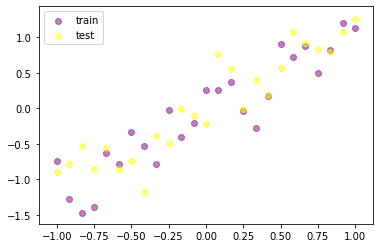

In [23]:
plt.scatter(X_train.data.numpy(),Y_train.data.numpy(),c = 'purple',alpha=0.5,label='train')
plt.scatter(X_test.data.numpy(),Y_test.data.numpy(),c='yellow', alpha = 0.5,label='test' )
plt.legend()
plt.show()


In [0]:
N_nodes = 100 

model = nn.Sequential(
    nn.Linear(1, N_nodes),
    nn.ReLU(),
    nn.Linear(N_nodes, N_nodes),
    nn.ReLU(),
    nn.Linear(N_nodes, 1)
)

model_dropout = nn.Sequential(
    nn.Linear(1, N_nodes),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(N_nodes, N_nodes),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(N_nodes,1)
)

In [0]:
opt = torch.optim.Adam(model.parameters(),lr=0.01 )
opt_dropout = torch.optim.Adam(model_dropout.parameters(),lr=0.01)
loss_fn = torch.nn.MSELoss()

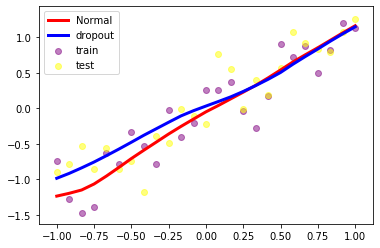

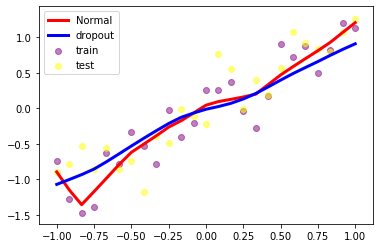

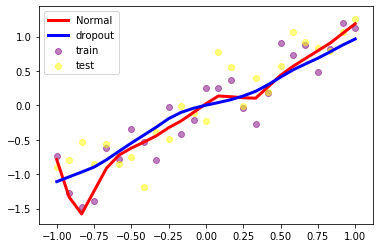

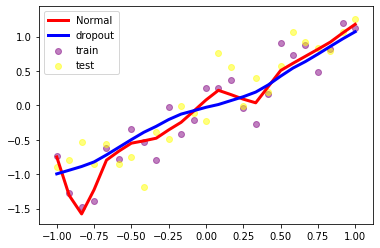

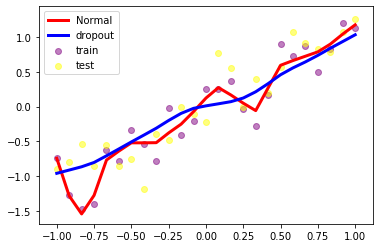

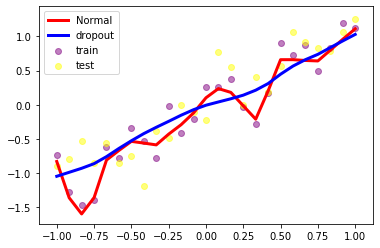

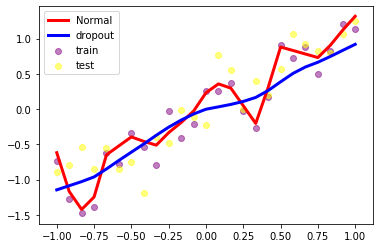

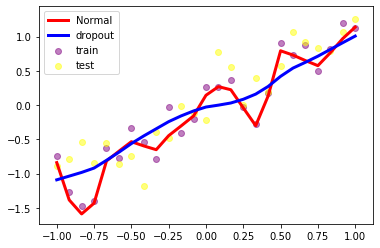

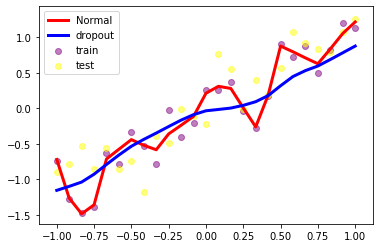

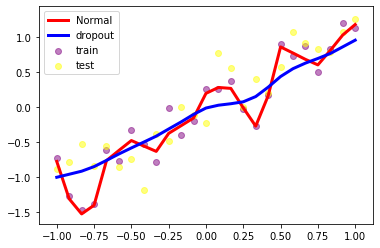

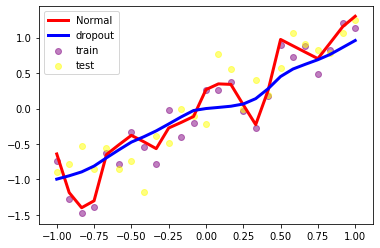

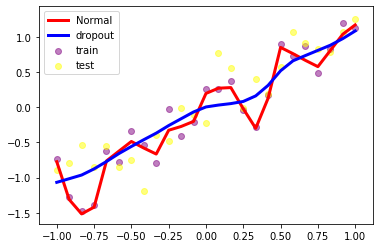

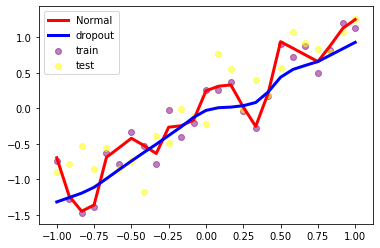

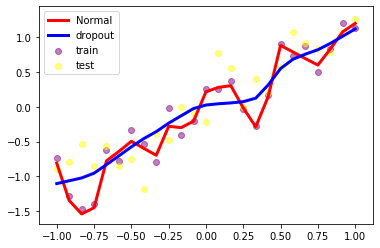

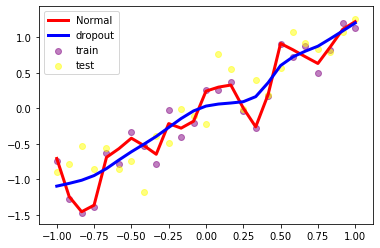

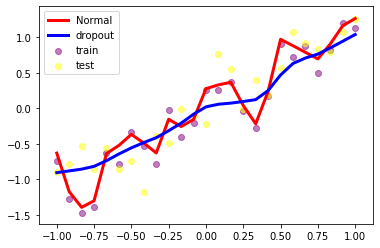

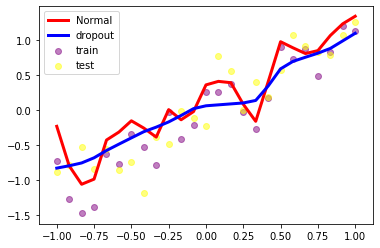

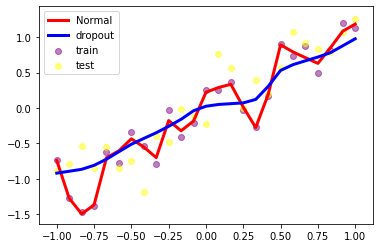

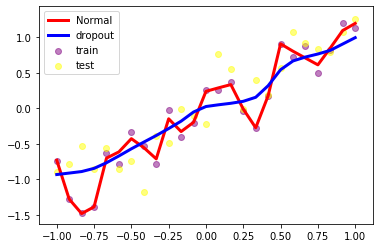

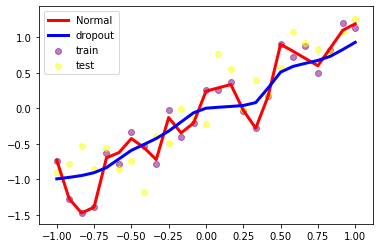

In [29]:
max_epochs = 1000

for epoch in range(max_epochs):

  opt.zero_grad()
  pred = model(X_train)
  loss = loss_fn(pred,Y_train)
  loss.backward()
  opt.step()

  opt_dropout.zero_grad()
  pred_dropout = model_dropout(X_train)
  loss_dropout = loss_fn(pred_dropout,Y_train)
  loss_dropout.backward()
  opt_dropout.step()

  if epoch % 50 == 0 :
    model.eval()
    model_dropout.eval()

    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, Y_test)

    test_pred_dropout = model_dropout(X_test)
    test_loss_dropout = loss_fn(test_pred_dropout,Y_test)

    plt.scatter(X_train.data.numpy(),Y_train.data.numpy(),c = 'purple',alpha=0.5,label='train')
    plt.scatter(X_test.data.numpy(),Y_test.data.numpy(),c='yellow', alpha = 0.5,label='test' )
    plt.plot(X_test.data.numpy(),test_pred.data.numpy(),'r-', lw=3,label = 'Normal')
    plt.plot(X_test.data.numpy(),test_pred_dropout.data.numpy(),'b-',lw=3, label = 'dropout')
    plt.legend()
    plt.show()
    model.train()
    model_dropout.train()
    plt.pause(0.5)






Dropout helps to avoid overfitting and also helps to get ensembled output 